# Optimal Strategy for Pretraining based Weight Initialization

One way to initialize the weights of an Artificial Neural Network (ANN) is to pretrain it using a small subset of the training data with fewer classes. Then, use those pretrained weights to fine-tune the network with full training data. Previously we have seen that pretraining based weight initialization technique significantly reduces the training time and achieves very high test accuracy. 

To implement the pretraining based initializer we need to determine what fraction of training data and classes should be used for pretraining. Generally it is beneficial to use a small subset of the training data. However, it is not clear whether we should use a small subset of the classes as well. By keeping the pretraining subset data fixed, we could either use a large fraction of the classes each with smaler instances, or a small subset of the classes each with larger number of instances. Which strategy should we use?

The goal of this notebook is to find that strategy. More specificaly, we determine the **optimal fraction of classes** to be used for pretraining an ANN. We keep the size of the pretraining subset fixed to 20% of the training data and vary the fraction of classes within the range 20% to 50%.


## Experimental Setting

For experimentation we use CIFAR10 dataset that has 45,000 training samples and 10 classes. We build a Convolutional Neural Network (CNN) with 4 hidden layers, 2 dense layers and a final classification layer.

In an experiment we initialize the weights of a CNN via pretraining. We use a small subset of the training data to train the CNN architecture. Then, using the pretrained layers (except the last two hidden layers and the final layer) as initial weights, we train the CNN using full training data. We conduct multiple experiments and in each of this vary the number of classes for pretraining. Finally, we determine the number of classes that gives best performance.

There are two steps in the pretraining based initialization approach:

- Step 1: Initialize weights by pretraining using a smaller subset of training data
- Step 2: Fine-tune the pretrained network using full training data

For the pretraining part, we use the orthogonal weight initializer and ELU activation function. The model is regularized by using increasing dropout rate in the 4 hidden layers: 0.2, 0.3, 0.4 and 0.5. 

We pretrain the model for 10 fixed epochs. Within 10 epochs the validation accuracy exceeds 95%.

We set the SGD learning rate using the 1cycle learning schedule. For this, first we find the maximum learning rate. Then, using the maximum learning rate for 1cycle schedule we pretrain the model.

For the fine-tuning, we use the weights of first 2 hidden layers of the pretrained model and add last two hidden layers as well as the output layer. These new layers are initialized using orthogonal weight initializer along with ELU activation. We use the same maximum learning rate for 1cycle learning schedule to train the model for fixed 100 epochs.

## Experiments

For all pretraining experiments we use 20% of the training data, and vary the number of classes from 20% to 50%. In each variation we keep the number of instances for each class equal.

- Experiment 1: Two Classes (20% of the classes)
- Experiment 2: Three Classes (30% of the classes)
- Experiment 3: Five Classes (50% of the classes)

In [1]:
import warnings
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization

In [3]:
# Check whether a GPU is added
tf.test.gpu_device_name()

'/device:GPU:0'

## Load and Scale the Dataset

In [4]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train_full = X_train_full.astype('float32')
X_test = X_test.astype('float32')

X_train = X_train_full[5000:]/255.0
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]/255.0
y_valid = y_train_full[:5000]

X_test = X_test/255.0

print("\nShape of Training Samples: ", X_train.shape)
print("Shape of Training Labels: ", y_train.shape)

print("\nShape of Validation Samples: ", X_valid.shape)
print("Shape of Validation Labels: ", y_valid.shape)

print("\nShape of Testing Samples: ", X_test.shape)
print("Shape of Testing Labels: ", y_test.shape)

print("\nData type: ", X_train.dtype)
print("Label type: ", y_train.dtype)

170500096/170498071 [==============================] - 2s 0us/step

Shape of Training Samples:  (45000, 32, 32, 3)
Shape of Training Labels:  (45000, 1)

Shape of Validation Samples:  (5000, 32, 32, 3)
Shape of Validation Labels:  (5000, 1)

Shape of Testing Samples:  (10000, 32, 32, 3)
Shape of Testing Labels:  (10000, 1)

Data type:  float32
Label type:  uint8


## Functions for Various Learning Curves & Converting Training Time

In [5]:
'''
Function For Generating Learning Curves (Accuracy & Loss)
'''
def plot_learning_curves(history, numOfEpochs, title):
    plt.figure(figsize=(18,6))

    plt.subplot(121)
    plt.plot(range(1,numOfEpochs+1),history.history['val_accuracy'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['accuracy'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Accuracy: "+title)
    
    plt.subplot(122)
    plt.plot(range(1,numOfEpochs+1),history.history['val_loss'],label='validation')
    plt.plot(range(1,numOfEpochs+1),history.history['loss'],label='training')
    plt.legend(loc=0)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xlim([1,numOfEpochs])
    plt.grid(True)
    plt.title("Model Loss: "+title)
    
    plt.show() 
    
    
# Plot learning rate & momentum
def plot_learning_rate(loss_history_lschedule, numOfEpochs, title, momentumPlot=False):
    plt.figure(figsize=(10,6))
    plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.lr,label='learning rate')
    plt.xlabel("Epoch")
    plt.xlim([1,numOfEpochs+1])
    plt.ylabel("Learning rate")
    
    if(momentumPlot==True):
        plt.plot(range(1,numOfEpochs+1),loss_history_lschedule.mom,'r-', label='momentum')
        plt.ylabel("Learning rate & Momentum")
    
    
    plt.legend(loc=0)
    plt.grid(True)
    plt.title(title)
    plt.show()

    
'''
Function to Convert Seconds into Hours, Minutes and Seconds
'''
def convertTime(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    if(hour == 0):
        return "{0:2.0f} min {1:2.0f} s".format(minutes, seconds) 
    
    elif(hour == 0 and minutes == 0):
        return "{1:2.0f} s".format(seconds) 
    
    else:
        return "{0:2.0f} h {1:2.0f} min {2:2.0f} s".format(hour, minutes, seconds) 

## Class to store the Changing Loss and Learning Rates

In [6]:
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))

## Class for 1cycle Learning Schedule

In [7]:
class OneCycle(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, momentum_vals=(0.95, 0.85), start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
        
        self.step_len =  int(self.iterations * (1 - 10.0/100.0)/2)
        
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    
    def on_batch_begin(self, batch, logs):
        
        # Set Learning Rate
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)
        
        
        # Set Momentum
        if self.iteration == 0:
            return self.high_mom
        elif self.iteration == self.iterations:
            self.iteration = 0
            return self.high_mom
        elif self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration - self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        K.set_value(self.model.optimizer.momentum, mom)

        
        
K = keras.backend
        
# A class to store the changing loss and learning rates at each epoch.
class LossHistory_OneCycle(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        self.mom = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(K.get_value(self.model.optimizer.lr))
        self.mom.append(K.get_value(self.model.optimizer.momentum))

## Function for Increasing Learning Rate

In [8]:
'''
A class to increase the learning rate by a "factor" at each iteration.
It stores the changing learning rate and loss at each iteration.
'''

K = keras.backend

class IncreaseLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
   

        
'''
Function to determine the "factor" to be used in the IncreaseLearningRate (above) object
'''
def computeFactorForIncreasingLearningRate(X, size_mini_batch, no_of_epochs, upper_bound_lr, lower_bound_lr):
    
    # Total number of iterations
    iterations = len(X) // size_mini_batch * no_of_epochs
    
    factor = np.exp(np.log(upper_bound_lr / lower_bound_lr) / iterations)
    
    return factor

## Experiment 1: 2 Classes for Pretraining (20% of the Classes)

We randomly select 2 classes and 4480 samples from each classs. Thus, the total training samples are 8960, which is slightly less than 20% of the training data.

## Experiment 1: Create Small Training & Validation Set

In [9]:
'''
Create a smaller training subset
'''

# Randomly select 2 class labels
class_labels_random = np.random.choice(10, 2, replace=False)


# variable to store the number of samples in a selected class
labels_class_1 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[0]):
        labels_class_1 +=1
        

# Arrays containing all samples from a selected class
X_train_class_1_all = np.zeros((labels_class_1, 32,32,3), 'float32')
y_train_class_1_all = np.zeros((labels_class_1, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[0]):
        X_train_class_1_all[j] = X_train[i]
        y_train_class_1_all[j] = y_train[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_train_class_1 = np.zeros((4480, 32,32,3), 'float32')
y_train_class_1 = np.zeros((4480, 1), 'uint8')




# Randomly select 4480 samples
class_labels_random_1 = np.random.choice(labels_class_1, 4480, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_1)):
    X_train_class_1[j] = X_train_class_1_all[class_labels_random_1[i]]
    y_train_class_1[j] = y_train_class_1_all[class_labels_random_1[i]]


print("Small Training Label: ", y_train_class_1[0])



labels_class_2 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[1]):
        labels_class_2 +=1
        
        
X_train_class_2_all = np.zeros((labels_class_2, 32,32,3), 'float32')
y_train_class_2_all = np.zeros((labels_class_2, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[1]):
        X_train_class_2_all[j] = X_train[i]
        y_train_class_2_all[j] = y_train[i]
        j += 1
        

X_train_class_2 = np.zeros((4480, 32,32,3), 'float32')
y_train_class_2 = np.zeros((4480, 1), 'uint8')


# Randomly select 4480 samples
class_labels_random_2 = np.random.choice(labels_class_2, 4480, replace=False)


j = 0
for i in range(len(class_labels_random_2)):
    X_train_class_2[j] = X_train_class_2_all[class_labels_random_2[i]]
    y_train_class_2[j] = y_train_class_2_all[class_labels_random_2[i]]

print("Small Training Label: ", y_train_class_2[0])


X_train_small_1 = np.concatenate((X_train_class_1, X_train_class_2), axis=0)
y_train_small_1 = np.concatenate((y_train_class_1, y_train_class_2), axis=0)

print("\nX_train_small_1: ", X_train_small_1.shape)
print("y_train_small_1: ", y_train_small_1.shape)

Small Training Label:  [7]
Small Training Label:  [5]

X_train_small_1:  (8960, 32, 32, 3)
y_train_small_1:  (8960, 1)


In [10]:
'''
Create a smaller validation subset
'''

# variable to store the number of samples in a selected class
labels_class_1 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[0]):
        labels_class_1 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_1_all = np.zeros((labels_class_1, 32,32,3), 'float32')
y_valid_class_1_all = np.zeros((labels_class_1, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[0]):
        X_valid_class_1_all[j] = X_valid[i]
        y_valid_class_1_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_1 = np.zeros((450, 32,32,3), 'float32')
y_valid_class_1 = np.zeros((450, 1), 'uint8')


# Randomly select 450 samples
class_labels_random_1 = np.random.choice(labels_class_1, 450, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_1)):
    X_valid_class_1[j] = X_valid_class_1_all[class_labels_random_1[i]]
    y_valid_class_1[j] = y_valid_class_1_all[class_labels_random_1[i]]


               
print("Small Training Label: ", y_valid_class_1[0])



# variable to store the number of samples in a selected class
labels_class_2 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[1]):
        labels_class_2 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_2_all = np.zeros((labels_class_2, 32,32,3), 'float32')
y_valid_class_2_all = np.zeros((labels_class_2, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[1]):
        X_valid_class_2_all[j] = X_valid[i]
        y_valid_class_2_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_2 = np.zeros((450, 32,32,3), 'float32')
y_valid_class_2 = np.zeros((450, 1), 'uint8')


# Randomly select 450 samples
class_labels_random_2 = np.random.choice(labels_class_2, 450, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_2)):
    X_valid_class_2[j] = X_valid_class_2_all[class_labels_random_2[i]]
    y_valid_class_2[j] = y_valid_class_2_all[class_labels_random_2[i]]


print("Small Training Label: ", y_valid_class_2[0])



X_valid_small_1 = np.concatenate((X_valid_class_1, X_valid_class_2), axis=0)
y_valid_small_1 = np.concatenate((y_valid_class_1, y_valid_class_2), axis=0)

print("\nX_valid_small_1: ", X_valid_small_1.shape)
print("y_valid_small_1: ", y_valid_small_1.shape)

Small Training Label:  [7]
Small Training Label:  [5]

X_valid_small_1:  (900, 32, 32, 3)
y_valid_small_1:  (900, 1)


## Find Maximum Learning Rate for 1cycle Schedule

In [11]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''
orthogonal_init = tf.keras.initializers.Orthogonal(gain=1.0)
initializer = orthogonal_init
activation_func = 'elu'

model = Sequential()
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



# Define the optimizer
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

'''
Create an IncreaseLearningRate object.
It increases the learning rate by some factor at each iteration:
We will start with a small learning rate of 1e-3.
'''
size_mini_batch = 64
no_of_epochs = 1
upper_bound_lr = 0.5
lower_bound_lr = 1e-3
increase_factor = computeFactorForIncreasingLearningRate(X_train_small_1, size_mini_batch, no_of_epochs, 
                                                         upper_bound_lr, lower_bound_lr)
increase_lr_cb = IncreaseLearningRate(factor=increase_factor)

'''
Train the model
'''
model.fit(X_train_small_1, y_train_small_1, 
                    batch_size=size_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small_1, y_valid_small_1),
                    callbacks=[increase_lr_cb])

140/140 [==============================] - 1s 9ms/step - loss: 0.4898 - accuracy: 0.9996 - val_loss: 0.0055 - val_accuracy: 0.9978
CPU times: user 2.84 s, sys: 641 ms, total: 3.49 s
Wall time: 8.19 s


## Pretraining -  Loss vs Learning Rate Plot

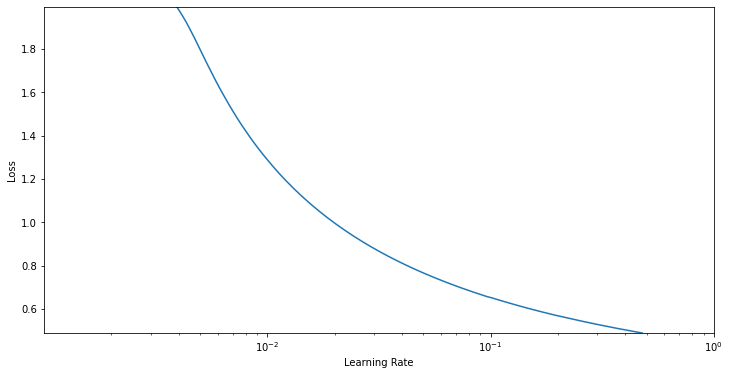

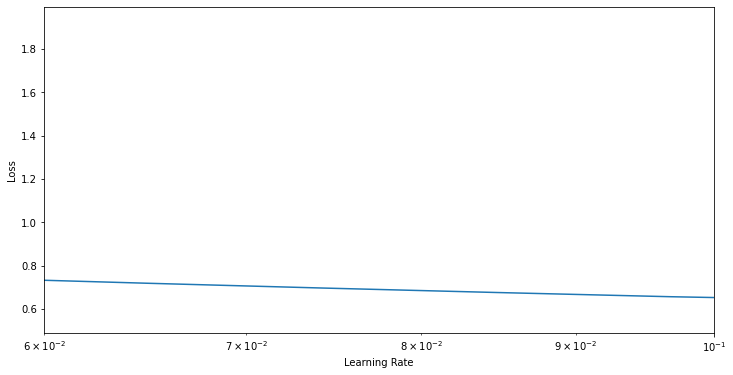

In [12]:
plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(min(increase_lr_cb.rates), 1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()


plt.figure(figsize = (12,6))
plt.plot(increase_lr_cb.rates, increase_lr_cb.losses)
plt.gca().set_xscale('log') # change the scale of learning rates to "log"
#plt.xlim(min(increase_lr_cb.rates), max(increase_lr_cb.rates))
plt.xlim(0.06, 0.1)
# The upper limit of y-axis should be set according to the heuristic given above
plt.ylim(min(increase_lr_cb.losses), (increase_lr_cb.losses[0] + min(increase_lr_cb.losses))/1.4)
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.show()

## Pretraining - 1cycle Max Learning Rate

We see from the above plot that loss is zero at near 0.5 learning rate. However, to avoid overshooting, we use 0.08 as the maximum learning rate for 1cycle schedule.

## Experiment 1: Weight Initialization by Pretraining

In [13]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

model_pretrained = Sequential()
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.2))

model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.3))

model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.4))

model_pretrained.add(Flatten())
model_pretrained.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model_pretrained.add(Dropout(0.5))
model_pretrained.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_Pretraining_1"
model_name_format = "CIFAR10_Pretraining_1.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 10
size_of_mini_batch = 32
no_iterations = (len(X_train_small_1) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_Pretraining_1 = model_pretrained.fit(X_train_small_1, y_train_small_1, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small_1, y_valid_small_1),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               loss_history_oneCycle_cb])
t1 = time.time()

duration_Pretraining_1_sec = t1-t0
duration_Pretraining_1 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Pretraining_1)
print("\n")


model_pretrained.save(model_name_format)

Epoch 1/10
280/280 [==============================] - 2s 7ms/step - loss: 0.0735 - accuracy: 0.9998 - val_loss: 0.0050 - val_accuracy: 0.9978
Epoch 2/10
280/280 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0043 - val_accuracy: 0.9978
Epoch 3/10
280/280 [==============================] - 2s 6ms/step - loss: 7.1446e-04 - accuracy: 0.9998 - val_loss: 0.0037 - val_accuracy: 0.9989
Epoch 4/10
280/280 [==============================] - 2s 6ms/step - loss: 7.5818e-04 - accuracy: 0.9998 - val_loss: 0.0033 - val_accuracy: 0.9989
Epoch 5/10
280/280 [==============================] - 2s 6ms/step - loss: 2.5383e-04 - accuracy: 0.9999 - val_loss: 0.0030 - val_accuracy: 0.9989
Epoch 6/10
280/280 [==============================] - 2s 6ms/step - loss: 2.5206e-04 - accuracy: 0.9999 - val_loss: 0.0029 - val_accuracy: 0.9989
Epoch 7/10
280/280 [==============================] - 2s 6ms/step - loss: 2.6786e-04 - accuracy: 0.9999 - val_loss: 0.0028 - val_acc

## Experiment 1: Transfer Pretrained Weights (Except Last Two Hidden Layers & Final Layer)

In [14]:
#model_pretrained = keras.models.load_model("CIFAR10_Pretraining_1.h5")

'''
We keep a copy of the pretrained model.
'''
model_pretrained_clone_Orthogonal = keras.models.clone_model(model_pretrained)
model_pretrained_clone_Orthogonal.set_weights(model_pretrained.get_weights())

print("No. of Pretrained Layers: ", len(model_pretrained.layers))

model_pretrained_clone_Orthogonal.summary()

'''
Create a new model using the pretrained model without the last two hidden layers ad the final layer.
Then, add two hidden layers followed by the final layer.
'''

model = keras.models.Sequential(model_pretrained.layers[0:8])

print("No. of Transfered Layers: ", len(model.layers))


model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

No. of Pretrained Layers:  16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

## Experiment 1: Fine-Tune the Pretrained Model with Full Training Data

In [15]:

'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_FineTuning_1"
model_name_format = "CIFAR10_FineTuning_1.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_FineTuning_1 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_FineTuning_1_sec = t1-t0
duration_FineTuning_1 = convertTime(duration_FineTuning_1_sec)
print("\nTraining Time: ", duration_FineTuning_1)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 6s 8ms/step - loss: 1.9620 - accuracy: 0.2815 - val_loss: 2.4512 - val_accuracy: 0.1762
Epoch 2/100
704/704 [==============================] - 6s 8ms/step - loss: 1.6450 - accuracy: 0.4036 - val_loss: 1.7831 - val_accuracy: 0.3670
Epoch 3/100
704/704 [==============================] - 6s 8ms/step - loss: 1.4648 - accuracy: 0.4711 - val_loss: 1.3584 - val_accuracy: 0.5260
Epoch 4/100
704/704 [==============================] - 6s 8ms/step - loss: 1.3350 - accuracy: 0.5254 - val_loss: 1.4452 - val_accuracy: 0.4940
Epoch 5/100
704/704 [==============================] - 6s 8ms/step - loss: 1.2228 - accuracy: 0.5659 - val_loss: 1.1627 - val_accuracy: 0.5906
Epoch 6/100
704/704 [==============================] - 6s 8ms/step - loss: 1.1412 - accuracy: 0.5971 - val_loss: 1.0841 - val_accuracy: 0.6190
Epoch 7/100
704/704 [==============================] - 5s 8ms/step - loss: 1.0804 - accuracy: 0.6215 - val_loss: 2.2486 - val_accuracy: 0.3968

Epochs:  100

CIFAR10_FineTuning_1 Test Accuracy: 0.870
CIFAR10_FineTuning_1 Test Loss: 0.541

Test Confusion Matrix:
[[870   7  34  10   7   3   3  10  34  22]
 [  6 920   0   1   1   1   2   0  16  53]
 [ 34   0 804  29  48  30  34  15   3   3]
 [ 11   2  39 733  40 109  31  18   6  11]
 [  5   1  37  20 885  14  18  17   3   0]
 [  6   0  25 107  30 793   7  28   2   2]
 [  4   1  25  25  17   4 910   9   4   1]
 [  8   2  11  19  29  24   1 902   2   2]
 [ 23   7   2   5   1   3   3   1 936  19]
 [ 12  21   2   6   2   0   1   0  13 943]]


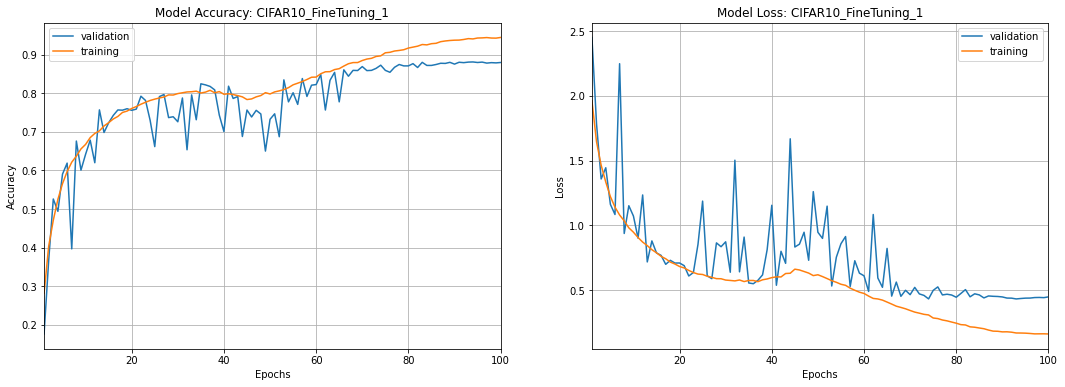

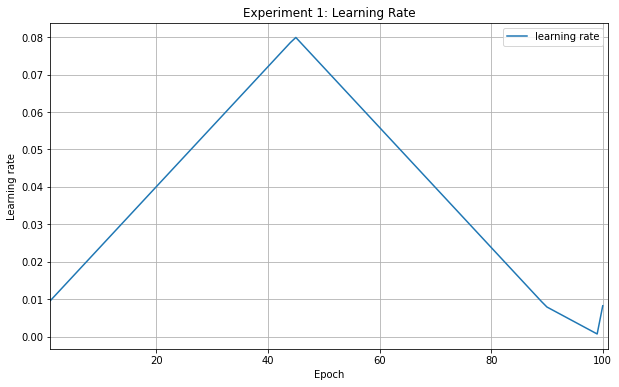

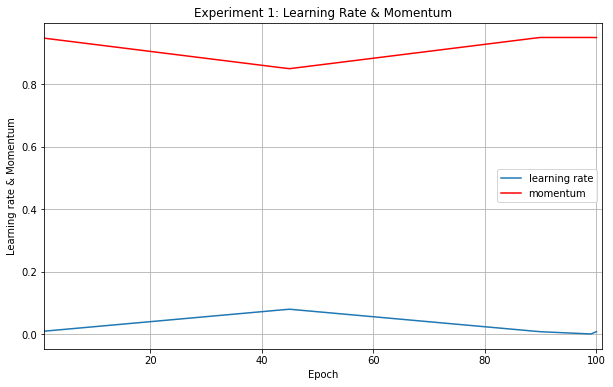

In [16]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_FineTuning_1.h5")

numOfEpochs_FineTuning_1 = len(history_FineTuning_1.history['loss'])
print("Epochs: ", numOfEpochs_FineTuning_1)

test_loss_FineTuning_1, test_accuracy_FineTuning_1 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_FineTuning_1))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_FineTuning_1))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_FineTuning_1, numOfEpochs_FineTuning_1, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_FineTuning_1, 
                   "Experiment 1: Learning Rate", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_FineTuning_1, 
                   "Experiment 1: Learning Rate & Momentum", momentumPlot=True)

## Experiment 2: 3 Classes for Pretraining (30% of the Classes)

We randomly select 3 classes and 3000 samples from each classs. Thus, the total training samples are 9000, which is 20% of the training data.

## Experiment 2: Create Small Training & Validation Set


In [17]:
'''
Create a smaller training subset
'''

# Randomly select 3 class labels
class_labels_random = np.random.choice(10, 3, replace=False)


labels_class_1 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[0]):
        labels_class_1 +=1
        
        
X_train_class_1_all = np.zeros((labels_class_1, 32,32,3), 'float32')
y_train_class_1_all = np.zeros((labels_class_1, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[0]):
        X_train_class_1_all[j] = X_train[i]
        y_train_class_1_all[j] = y_train[i]
        j += 1
        

X_train_class_1 = np.zeros((3000, 32,32,3), 'float32')
y_train_class_1 = np.zeros((3000, 1), 'uint8')


# Randomly select 3000 samples
class_labels_random_1 = np.random.choice(labels_class_1, 3000, replace=False)



j = 0
for i in range(len(class_labels_random_1)):
    X_train_class_1[j] = X_train_class_1_all[class_labels_random_1[i]]
    y_train_class_1[j] = y_train_class_1_all[class_labels_random_1[i]]


print("Small Training Label: ", y_train_class_1[0])


labels_class_2 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[1]):
        labels_class_2 +=1
        
        
X_train_class_2_all = np.zeros((labels_class_2, 32,32,3), 'float32')
y_train_class_2_all = np.zeros((labels_class_2, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[1]):
        X_train_class_2_all[j] = X_train[i]
        y_train_class_2_all[j] = y_train[i]
        j += 1
        

X_train_class_2 = np.zeros((3000, 32,32,3), 'float32')
y_train_class_2 = np.zeros((3000, 1), 'uint8')


# Randomly select 3000 samples
class_labels_random_2 = np.random.choice(labels_class_2, 3000, replace=False)


j = 0
for i in range(len(class_labels_random_2)):
    X_train_class_2[j] = X_train_class_2_all[class_labels_random_2[i]]
    y_train_class_2[j] = y_train_class_2_all[class_labels_random_2[i]]



print("Small Training Label: ", y_train_class_2[0])






labels_class_3 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[2]):
        labels_class_3 +=1
        
        
X_train_class_3_all = np.zeros((labels_class_3, 32,32,3), 'float32')
y_train_class_3_all = np.zeros((labels_class_3, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[2]):
        X_train_class_3_all[j] = X_train[i]
        y_train_class_3_all[j] = y_train[i]
        j += 1
        

X_train_class_3 = np.zeros((3000, 32,32,3), 'float32')
y_train_class_3 = np.zeros((3000, 1), 'uint8')


# Randomly select 3000 samples
class_labels_random_3 = np.random.choice(labels_class_3, 3000, replace=False)


j = 0
for i in range(len(class_labels_random_3)):
    X_train_class_3[j] = X_train_class_3_all[class_labels_random_3[i]]
    y_train_class_3[j] = y_train_class_3_all[class_labels_random_3[i]]


print("Small Training Label: ", y_train_class_3[0])





X_train_small_2 = np.concatenate((X_train_class_1, X_train_class_2, X_train_class_3), axis=0)
y_train_small_2 = np.concatenate((y_train_class_1, y_train_class_2, y_train_class_3), axis=0)

print("\nX_train_small_2: ", X_train_small_2.shape)
print("y_train_small_2: ", y_train_small_2.shape)

Small Training Label:  [8]
Small Training Label:  [1]
Small Training Label:  [5]

X_train_small_2:  (9000, 32, 32, 3)
y_train_small_2:  (9000, 1)


In [18]:
'''
Create a smaller validation subset
'''

# variable to store the number of samples in a selected class
labels_class_1 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[0]):
        labels_class_1 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_1_all = np.zeros((labels_class_1, 32,32,3), 'float32')
y_valid_class_1_all = np.zeros((labels_class_1, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[0]):
        X_valid_class_1_all[j] = X_valid[i]
        y_valid_class_1_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_1 = np.zeros((300, 32,32,3), 'float32')
y_valid_class_1 = np.zeros((300, 1), 'uint8')


# Randomly select 300 samples
class_labels_random_1 = np.random.choice(labels_class_1, 300, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_1)):
    X_valid_class_1[j] = X_valid_class_1_all[class_labels_random_1[i]]
    y_valid_class_1[j] = y_valid_class_1_all[class_labels_random_1[i]]


        
print("Small Training Label: ", y_valid_class_1[0])


# variable to store the number of samples in a selected class
labels_class_2 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[1]):
        labels_class_2 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_2_all = np.zeros((labels_class_2, 32,32,3), 'float32')
y_valid_class_2_all = np.zeros((labels_class_2, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[1]):
        X_valid_class_2_all[j] = X_valid[i]
        y_valid_class_2_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_2 = np.zeros((300, 32,32,3), 'float32')
y_valid_class_2 = np.zeros((300, 1), 'uint8')


# Randomly select 300 samples
class_labels_random_2 = np.random.choice(labels_class_2, 300, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_2)):
    X_valid_class_2[j] = X_valid_class_2_all[class_labels_random_2[i]]
    y_valid_class_2[j] = y_valid_class_2_all[class_labels_random_2[i]]


               
print("Small Training Label: ", y_valid_class_2[0])


# variable to store the number of samples in a selected class
labels_class_3 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[2]):
        labels_class_3 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_3_all = np.zeros((labels_class_3, 32,32,3), 'float32')
y_valid_class_3_all = np.zeros((labels_class_3, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[2]):
        X_valid_class_3_all[j] = X_valid[i]
        y_valid_class_3_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_3 = np.zeros((300, 32,32,3), 'float32')
y_valid_class_3 = np.zeros((300, 1), 'uint8')


# Randomly select 300 samples
class_labels_random_3 = np.random.choice(labels_class_3, 300, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_3)):
    X_valid_class_3[j] = X_valid_class_3_all[class_labels_random_3[i]]
    y_valid_class_3[j] = y_valid_class_3_all[class_labels_random_3[i]]


print("Small Training Label: ", y_valid_class_3[0])

X_valid_small_2 = np.concatenate((X_valid_class_1, X_valid_class_2, X_valid_class_3), axis=0)
y_valid_small_2 = np.concatenate((y_valid_class_1, y_valid_class_2, y_valid_class_3), axis=0)

print("\nX_valid_small_2: ", X_valid_small_2.shape)
print("y_valid_small_2: ", y_valid_small_2.shape)

Small Training Label:  [8]
Small Training Label:  [1]
Small Training Label:  [5]

X_valid_small_2:  (900, 32, 32, 3)
y_valid_small_2:  (900, 1)




## Experiment 2: Weight Initialization by Pretraining 

In [19]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

model_pretrained = Sequential()
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.2))

model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.3))

model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.4))

model_pretrained.add(Flatten())
model_pretrained.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model_pretrained.add(Dropout(0.5))
model_pretrained.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_Pretraining_2"
model_name_format = "CIFAR10_Pretraining_2.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 10
size_of_mini_batch = 32
no_iterations = (len(X_train_small_2) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_Pretraining_2 = model_pretrained.fit(X_train_small_2, y_train_small_2, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small_2, y_valid_small_2),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               loss_history_oneCycle_cb])
t1 = time.time()

duration_Pretraining_2_sec = t1-t0
duration_Pretraining_2 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Pretraining_2)
print("\n")


model_pretrained.save(model_name_format)

Epoch 1/10
282/282 [==============================] - 2s 7ms/step - loss: 0.0735 - accuracy: 0.9997 - val_loss: 0.0082 - val_accuracy: 0.9967
Epoch 2/10
282/282 [==============================] - 2s 6ms/step - loss: 8.4182e-04 - accuracy: 0.9999 - val_loss: 0.0077 - val_accuracy: 0.9967
Epoch 3/10
282/282 [==============================] - 2s 6ms/step - loss: 7.7033e-04 - accuracy: 0.9998 - val_loss: 0.0066 - val_accuracy: 0.9967
Epoch 4/10
282/282 [==============================] - 2s 6ms/step - loss: 7.7044e-04 - accuracy: 0.9998 - val_loss: 0.0127 - val_accuracy: 0.9967
Epoch 5/10
282/282 [==============================] - 2s 6ms/step - loss: 6.5779e-04 - accuracy: 0.9998 - val_loss: 0.0070 - val_accuracy: 0.9978
Epoch 6/10
282/282 [==============================] - 2s 6ms/step - loss: 6.3274e-04 - accuracy: 0.9997 - val_loss: 0.0056 - val_accuracy: 0.9978
Epoch 7/10
282/282 [==============================] - 2s 6ms/step - loss: 6.3819e-04 - accuracy: 0.9997 - val_loss: 0.0056 - val

## Experiment 2: Transfer Pretrained Weights (Except Last Two Hidden Layers & Final Layer)

In [20]:
#model_pretrained = keras.models.load_model("CIFAR10_Pretraining_2.h5")

'''
We keep a copy of the pretrained model.
'''
model_pretrained_clone_Orthogonal = keras.models.clone_model(model_pretrained)
model_pretrained_clone_Orthogonal.set_weights(model_pretrained.get_weights())

print("No. of Pretrained Layers: ", len(model_pretrained.layers))

model_pretrained_clone_Orthogonal.summary()

'''
Create a new model using the pretrained model without the last two hidden layers ad the final layer.
Then, add two hidden layers followed by the final layer.
'''

model = keras.models.Sequential(model_pretrained.layers[0:8])

print("No. of Transfered Layers: ", len(model.layers))


model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

No. of Pretrained Layers:  16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

## Experiment 2: Fine-Tune the Pretrained Model with Full Training Data

In [21]:
'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_FineTuning_2"
model_name_format = "CIFAR10_FineTuning_2.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_FineTuning_2 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_FineTuning_2_sec = t1-t0
duration_FineTuning_2 = convertTime(duration_FineTuning_2_sec)
print("\nTraining Time: ", duration_FineTuning_2)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 6s 8ms/step - loss: 1.9595 - accuracy: 0.2840 - val_loss: 2.5050 - val_accuracy: 0.1718
Epoch 2/100
704/704 [==============================] - 5s 8ms/step - loss: 1.6461 - accuracy: 0.4039 - val_loss: 1.7434 - val_accuracy: 0.3752
Epoch 3/100
704/704 [==============================] - 5s 8ms/step - loss: 1.4654 - accuracy: 0.4702 - val_loss: 1.4260 - val_accuracy: 0.5094
Epoch 4/100
704/704 [==============================] - 5s 8ms/step - loss: 1.3352 - accuracy: 0.5250 - val_loss: 1.4295 - val_accuracy: 0.5004
Epoch 5/100
704/704 [==============================] - 5s 8ms/step - loss: 1.2220 - accuracy: 0.5665 - val_loss: 1.1689 - val_accuracy: 0.5886
Epoch 6/100
704/704 [==============================] - 5s 8ms/step - loss: 1.1415 - accuracy: 0.5965 - val_loss: 1.1367 - val_accuracy: 0.6004
Epoch 7/100
704/704 [==============================] - 5s 8ms/step - loss: 1.0801 - accuracy: 0.6228 - val_loss: 2.1766 - val_accuracy: 0.4072

Epochs:  100

CIFAR10_FineTuning_2 Test Accuracy: 0.876
CIFAR10_FineTuning_2 Test Loss: 0.509

Test Confusion Matrix:
[[874   7  35   7   6   1   2   7  40  21]
 [  8 930   0   1   2   1   3   0  16  39]
 [ 35   0 813  19  38  35  36  13   7   4]
 [ 12   3  44 740  35  89  47  13   6  11]
 [  8   1  33  26 885  12  14  17   3   1]
 [  7   1  20 122  29 789   6  22   3   1]
 [  5   2  16  19  12   4 932   4   3   3]
 [  5   0  11  26  25  26   2 903   0   2]
 [ 22   3   5   3   0   2   1   2 948  14]
 [ 12  17   2   3   2   0   2   0  12 950]]


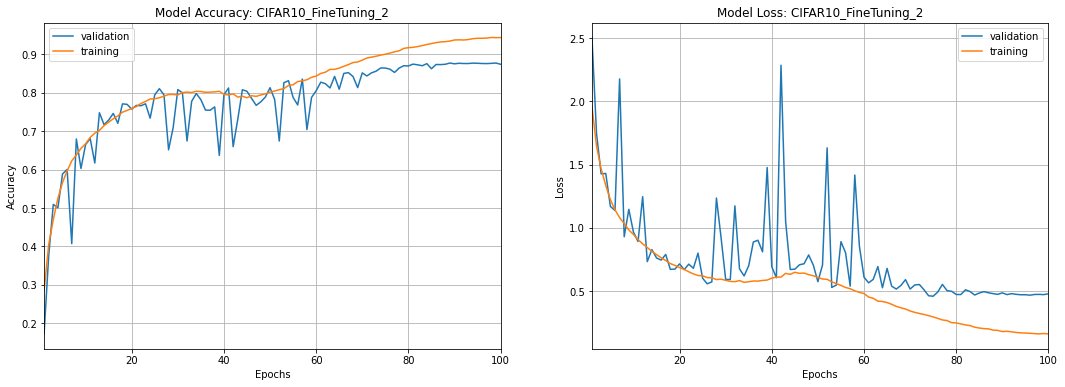

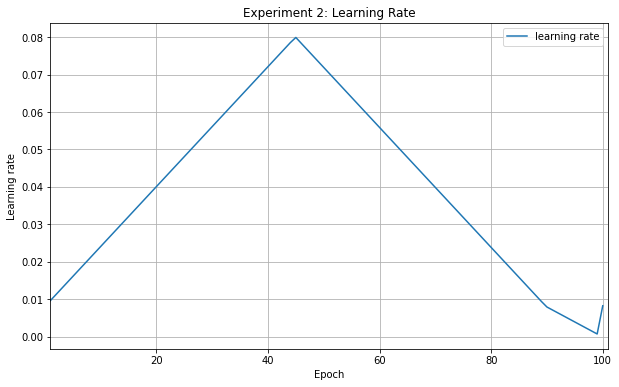

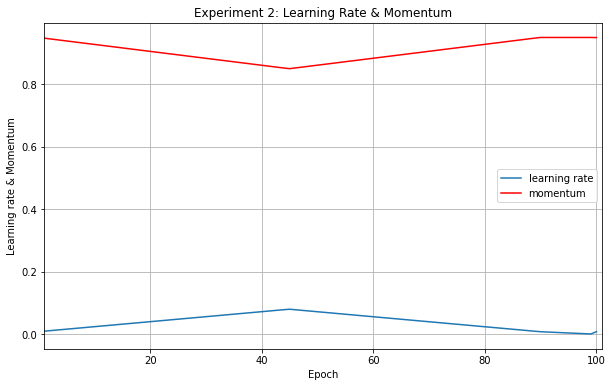

In [22]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_FineTuning_2.h5")

numOfEpochs_FineTuning_2 = len(history_FineTuning_2.history['loss'])
print("Epochs: ", numOfEpochs_FineTuning_2)

test_loss_FineTuning_2, test_accuracy_FineTuning_2 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_FineTuning_2))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_FineTuning_2))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_FineTuning_2, numOfEpochs_FineTuning_2, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_FineTuning_2, 
                   "Experiment 2: Learning Rate", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_FineTuning_2, 
                   "Experiment 2: Learning Rate & Momentum", momentumPlot=True)

## Experiment 3: 5 Classes for Pretraining (50% of the Classes)

We randomly select 5 classes and 1800 samples from each classs. Thus, the total training samples are 9000, which is 20% of the training data.

## Experiment 3: Create Small Training & Validation Set

In [23]:
'''
Create a smaller training subset
'''

# Randomly select 5 class labels
class_labels_random = np.random.choice(10, 5, replace=False)


labels_class_1 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[0]):
        labels_class_1 +=1
        
        
X_train_class_1_all = np.zeros((labels_class_1, 32,32,3), 'float32')
y_train_class_1_all = np.zeros((labels_class_1, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[0]):
        X_train_class_1_all[j] = X_train[i]
        y_train_class_1_all[j] = y_train[i]
        j += 1
        

X_train_class_1 = np.zeros((1800, 32,32,3), 'float32')
y_train_class_1 = np.zeros((1800, 1), 'uint8')


# Randomly select 1800 samples
class_labels_random_1 = np.random.choice(labels_class_1, 1800, replace=False)



j = 0
for i in range(len(class_labels_random_1)):
    X_train_class_1[j] = X_train_class_1_all[class_labels_random_1[i]]
    y_train_class_1[j] = y_train_class_1_all[class_labels_random_1[i]]


print("Small Training Label: ", y_train_class_1[0])


labels_class_2 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[1]):
        labels_class_2 +=1
        
        
X_train_class_2_all = np.zeros((labels_class_2, 32,32,3), 'float32')
y_train_class_2_all = np.zeros((labels_class_2, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[1]):
        X_train_class_2_all[j] = X_train[i]
        y_train_class_2_all[j] = y_train[i]
        j += 1
        

X_train_class_2 = np.zeros((1800, 32,32,3), 'float32')
y_train_class_2 = np.zeros((1800, 1), 'uint8')


# Randomly select 1800 samples
class_labels_random_2 = np.random.choice(labels_class_2, 1800, replace=False)


j = 0
for i in range(len(class_labels_random_2)):
    X_train_class_2[j] = X_train_class_2_all[class_labels_random_2[i]]
    y_train_class_2[j] = y_train_class_2_all[class_labels_random_2[i]]


print("Small Training Label: ", y_train_class_2[0])



labels_class_3 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[2]):
        labels_class_3 +=1
        
        
X_train_class_3_all = np.zeros((labels_class_3, 32,32,3), 'float32')
y_train_class_3_all = np.zeros((labels_class_3, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[2]):
        X_train_class_3_all[j] = X_train[i]
        y_train_class_3_all[j] = y_train[i]
        j += 1
        

X_train_class_3 = np.zeros((1800, 32,32,3), 'float32')
y_train_class_3 = np.zeros((1800, 1), 'uint8')


# Randomly select 1800 samples
class_labels_random_3 = np.random.choice(labels_class_3, 1800, replace=False)


j = 0
for i in range(len(class_labels_random_3)):
    X_train_class_3[j] = X_train_class_3_all[class_labels_random_3[i]]
    y_train_class_3[j] = y_train_class_3_all[class_labels_random_3[i]]


print("Small Training Label: ", y_train_class_3[0])



labels_class_4 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[3]):
        labels_class_4 +=1
        
        
X_train_class_4_all = np.zeros((labels_class_4, 32,32,3), 'float32')
y_train_class_4_all = np.zeros((labels_class_4, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[3]):
        X_train_class_4_all[j] = X_train[i]
        y_train_class_4_all[j] = y_train[i]
        j += 1
        

X_train_class_4 = np.zeros((1800, 32,32,3), 'float32')
y_train_class_4 = np.zeros((1800, 1), 'uint8')


# Randomly select 1800 samples
class_labels_random_4 = np.random.choice(labels_class_4, 1800, replace=False)


j = 0
for i in range(len(class_labels_random_4)):
    X_train_class_4[j] = X_train_class_4_all[class_labels_random_4[i]]
    y_train_class_4[j] = y_train_class_4_all[class_labels_random_4[i]]


print("Small Training Label: ", y_train_class_4[0])


labels_class_5 = 0
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[4]):
        labels_class_5 +=1
        
        
X_train_class_5_all = np.zeros((labels_class_5, 32,32,3), 'float32')
y_train_class_5_all = np.zeros((labels_class_5, 1), 'uint8')


j = 0 
for i in range(X_train.shape[0]):
    if(y_train[i] == class_labels_random[4]):
        X_train_class_5_all[j] = X_train[i]
        y_train_class_5_all[j] = y_train[i]
        j += 1
        

X_train_class_5 = np.zeros((1800, 32,32,3), 'float32')
y_train_class_5 = np.zeros((1800, 1), 'uint8')


# Randomly select 1800 samples
class_labels_random_5 = np.random.choice(labels_class_5, 1800, replace=False)


j = 0
for i in range(len(class_labels_random_5)):
    X_train_class_5[j] = X_train_class_5_all[class_labels_random_5[i]]
    y_train_class_5[j] = y_train_class_5_all[class_labels_random_5[i]]


print("Small Training Label: ", y_train_class_5[0])





X_train_small_3 = np.concatenate((X_train_class_1, X_train_class_2, X_train_class_3, 
                                  X_train_class_4, X_train_class_5), axis=0)
y_train_small_3 = np.concatenate((y_train_class_1, y_train_class_2, y_train_class_3, 
                                  y_train_class_4, y_train_class_5), axis=0)

print("\nX_train_small_2: ", X_train_small_3.shape)
print("y_train_small_2: ", y_train_small_3.shape)

Small Training Label:  [8]
Small Training Label:  [1]
Small Training Label:  [5]
Small Training Label:  [0]
Small Training Label:  [7]

X_train_small_2:  (9000, 32, 32, 3)
y_train_small_2:  (9000, 1)


In [24]:
'''
Create a smaller validation subset
'''

# variable to store the number of samples in a selected class
labels_class_1 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[0]):
        labels_class_1 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_1_all = np.zeros((labels_class_1, 32,32,3), 'float32')
y_valid_class_1_all = np.zeros((labels_class_1, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[0]):
        X_valid_class_1_all[j] = X_valid[i]
        y_valid_class_1_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_1 = np.zeros((190, 32,32,3), 'float32')
y_valid_class_1 = np.zeros((190, 1), 'uint8')


# Randomly select 190 samples
class_labels_random_1 = np.random.choice(labels_class_1, 190, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_1)):
    X_valid_class_1[j] = X_valid_class_1_all[class_labels_random_1[i]]
    y_valid_class_1[j] = y_valid_class_1_all[class_labels_random_1[i]]


print("Small Training Label: ", y_valid_class_1[0])


# variable to store the number of samples in a selected class
labels_class_2 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[1]):
        labels_class_2 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_2_all = np.zeros((labels_class_2, 32,32,3), 'float32')
y_valid_class_2_all = np.zeros((labels_class_2, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[1]):
        X_valid_class_2_all[j] = X_valid[i]
        y_valid_class_2_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_2 = np.zeros((190, 32,32,3), 'float32')
y_valid_class_2 = np.zeros((190, 1), 'uint8')


# Randomly select 190 samples
class_labels_random_2 = np.random.choice(labels_class_2, 190, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_2)):
    X_valid_class_2[j] = X_valid_class_2_all[class_labels_random_2[i]]
    y_valid_class_2[j] = y_valid_class_2_all[class_labels_random_2[i]]

print("Small Training Label: ", y_valid_class_2[0])


# variable to store the number of samples in a selected class
labels_class_3 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[2]):
        labels_class_3 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_3_all = np.zeros((labels_class_3, 32,32,3), 'float32')
y_valid_class_3_all = np.zeros((labels_class_3, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[2]):
        X_valid_class_3_all[j] = X_valid[i]
        y_valid_class_3_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_3 = np.zeros((190, 32,32,3), 'float32')
y_valid_class_3 = np.zeros((190, 1), 'uint8')


# Randomly select 190 samples
class_labels_random_3 = np.random.choice(labels_class_3, 190, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_3)):
    X_valid_class_3[j] = X_valid_class_3_all[class_labels_random_3[i]]
    y_valid_class_3[j] = y_valid_class_3_all[class_labels_random_3[i]]

print("Small Training Label: ", y_valid_class_3[0])


# variable to store the number of samples in a selected class
labels_class_4 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[3]):
        labels_class_4 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_4_all = np.zeros((labels_class_4, 32,32,3), 'float32')
y_valid_class_4_all = np.zeros((labels_class_4, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[3]):
        X_valid_class_4_all[j] = X_valid[i]
        y_valid_class_4_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_4 = np.zeros((190, 32,32,3), 'float32')
y_valid_class_4 = np.zeros((190, 1), 'uint8')


# Randomly select 190 samples
class_labels_random_4 = np.random.choice(labels_class_4, 190, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_4)):
    X_valid_class_4[j] = X_valid_class_4_all[class_labels_random_4[i]]
    y_valid_class_4[j] = y_valid_class_4_all[class_labels_random_4[i]]


print("Small Training Label: ", y_valid_class_4[0])



# variable to store the number of samples in a selected class
labels_class_5 = 0
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[4]):
        labels_class_5 +=1
        

# Arrays containing all samples from a selected class
X_valid_class_5_all = np.zeros((labels_class_5, 32,32,3), 'float32')
y_valid_class_5_all = np.zeros((labels_class_5, 1), 'uint8')


# Store ALL samples of a selected class in the above arrays
j = 0 
for i in range(X_valid.shape[0]):
    if(y_valid[i] == class_labels_random[4]):
        X_valid_class_5_all[j] = X_valid[i]
        y_valid_class_5_all[j] = y_valid[i]
        j += 1
        

# Arrays containing a subset of samples from a selected class
X_valid_class_5 = np.zeros((190, 32,32,3), 'float32')
y_valid_class_5 = np.zeros((190, 1), 'uint8')


# Randomly select 190 samples
class_labels_random_5 = np.random.choice(labels_class_5, 190, replace=False)


# Store randomly selected subset of samples of a selected class in the above arrays
j = 0
for i in range(len(class_labels_random_5)):
    X_valid_class_5[j] = X_valid_class_5_all[class_labels_random_5[i]]
    y_valid_class_5[j] = y_valid_class_5_all[class_labels_random_5[i]]

print("Small Training Label: ", y_valid_class_5[0])


X_valid_small_3 = np.concatenate((X_valid_class_1, X_valid_class_2, X_valid_class_3, 
                                  X_valid_class_4, X_valid_class_5), axis=0)
y_valid_small_3 = np.concatenate((y_valid_class_1, y_valid_class_2, y_valid_class_3, 
                                  y_valid_class_4, y_valid_class_5), axis=0)

print("\nX_valid_small_3: ", X_valid_small_3.shape)
print("y_valid_small_3: ", y_valid_small_3.shape)

Small Training Label:  [8]
Small Training Label:  [1]
Small Training Label:  [5]
Small Training Label:  [0]
Small Training Label:  [7]

X_valid_small_3:  (950, 32, 32, 3)
y_valid_small_3:  (950, 1)


## Experiment 3: Weight Initialization by Pretraining

In [25]:
%%time

'''
Delete the TensorFlow graph before creating a new model, otherwise memory overflow will occur.
'''
keras.backend.clear_session()

'''
To reproduce the same result by the model in each iteration, we use fixed seeds for random number generation. 
'''
np.random.seed(42)
tf.random.set_seed(42)


'''
Create a Sequential model composed of a single stack of layers connected sequentially. 
'''

model_pretrained = Sequential()
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same', input_shape=(32, 32, 3)))
model_pretrained.add(Conv2D(32, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.2))

model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(64, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.3))

model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model_pretrained.add(MaxPooling2D((2, 2)))
model_pretrained.add(Dropout(0.4))

model_pretrained.add(Flatten())
model_pretrained.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model_pretrained.add(Dropout(0.5))
model_pretrained.add(Dense(10, activation='softmax'))



'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model_pretrained.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_Pretraining_3"
model_name_format = "CIFAR10_Pretraining_3.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 10
size_of_mini_batch = 32
no_iterations = (len(X_train_small_3) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_Pretraining_3 = model_pretrained.fit(X_train_small_3, y_train_small_3, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid_small_3, y_valid_small_3),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb,
                               loss_history_oneCycle_cb])
t1 = time.time()

duration_Pretraining_3_sec = t1-t0
duration_Pretraining_3 = convertTime(t1 - t0)
print("\nTraining Time: ", duration_Pretraining_3)
print("\n")


model_pretrained.save(model_name_format)

Epoch 1/10
282/282 [==============================] - 2s 7ms/step - loss: 0.0747 - accuracy: 0.9994 - val_loss: 0.0130 - val_accuracy: 0.9958
Epoch 2/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0115 - val_accuracy: 0.9958
Epoch 3/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.0134 - val_accuracy: 0.9958
Epoch 4/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0025 - accuracy: 0.9994 - val_loss: 0.0222 - val_accuracy: 0.9958
Epoch 5/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0109 - val_accuracy: 0.9958
Epoch 6/10
282/282 [==============================] - 2s 6ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.0132 - val_accuracy: 0.9947
Epoch 7/10
282/282 [==============================] - 2s 6ms/step - loss: 8.2530e-04 - accuracy: 0.9998 - val_loss: 0.0105 - val_accuracy: 0.9958
Ep

## Experiment 3: Transfer Pretrained Weights (Except Last Two Hidden Layers & Final Layer)

In [26]:
#model_pretrained = keras.models.load_model("CIFAR10_Pretraining_3.h5")

'''
We keep a copy of the pretrained model.
'''
model_pretrained_clone_Orthogonal = keras.models.clone_model(model_pretrained)
model_pretrained_clone_Orthogonal.set_weights(model_pretrained.get_weights())

print("No. of Pretrained Layers: ", len(model_pretrained.layers))

model_pretrained_clone_Orthogonal.summary()

'''
Create a new model using the pretrained model without the last two hidden layers ad the final layer.
Then, add two hidden layers followed by the final layer.
'''

model = keras.models.Sequential(model_pretrained.layers[0:8])

print("No. of Transfered Layers: ", len(model.layers))


model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(Conv2D(128, (3, 3), activation=activation_func, kernel_initializer=initializer, padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.4))


model.add(Flatten())
model.add(Dense(128, activation=activation_func, kernel_initializer=initializer))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

No. of Pretrained Layers:  16
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPoolin

## Experiment 3: Fine-Tune the Pretrained Model with Full Training Data

In [27]:

'''
Define the optimizer
'''
optimizer=keras.optimizers.SGD(learning_rate=1e-3)


'''
Compile the model
'''
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


loss_history_oneCycle_cb = LossHistory_OneCycle()


model_name = "CIFAR10_FineTuning_3"
model_name_format = "CIFAR10_FineTuning_3.h5"


'''
Create a path for the log sub-directory by concatenating three information:
    Root log directory + Current date and time + Model Name
'''
run_logdir = os.path.join(os.curdir, "my_logs", time.strftime("run_%Y_%m_%d-%H_%M_%S"), model_name)


'''
Create a TensorBoard "callback" object to enable visualizations for TensorBoard.
'''
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)


'''
Create model checkpoint callback to save only the best performing models.
'''
checkpoint_cb = keras.callbacks.ModelCheckpoint(model_name_format, save_best_only=True)



no_of_epochs = 100
size_of_mini_batch = 64
no_iterations = (len(X_train) // size_of_mini_batch) * no_of_epochs


lschedule_oneCycle_cb = OneCycle(no_iterations, max_rate=0.08, momentum_vals=(0.95, 0.85))


t0 = time.time()
history_FineTuning_3 = model.fit(X_train, y_train, 
                    batch_size=size_of_mini_batch, 
                    epochs=no_of_epochs,
                    verbose=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb, checkpoint_cb, lschedule_oneCycle_cb, loss_history_oneCycle_cb])
t1 = time.time()

duration_FineTuning_3_sec = t1-t0
duration_FineTuning_3 = convertTime(duration_FineTuning_3_sec)
print("\nTraining Time: ", duration_FineTuning_3)
print("\n")


model.save(model_name_format)

Epoch 1/100
704/704 [==============================] - 5s 8ms/step - loss: 1.9485 - accuracy: 0.2882 - val_loss: 2.4025 - val_accuracy: 0.1888
Epoch 2/100
704/704 [==============================] - 5s 7ms/step - loss: 1.6397 - accuracy: 0.4068 - val_loss: 1.6853 - val_accuracy: 0.3926
Epoch 3/100
704/704 [==============================] - 5s 8ms/step - loss: 1.4629 - accuracy: 0.4696 - val_loss: 1.4240 - val_accuracy: 0.5068
Epoch 4/100
704/704 [==============================] - 5s 8ms/step - loss: 1.3362 - accuracy: 0.5249 - val_loss: 1.4206 - val_accuracy: 0.4984
Epoch 5/100
704/704 [==============================] - 5s 8ms/step - loss: 1.2229 - accuracy: 0.5662 - val_loss: 1.1348 - val_accuracy: 0.5994
Epoch 6/100
704/704 [==============================] - 5s 8ms/step - loss: 1.1442 - accuracy: 0.5966 - val_loss: 1.1144 - val_accuracy: 0.6092
Epoch 7/100
704/704 [==============================] - 5s 8ms/step - loss: 1.0805 - accuracy: 0.6209 - val_loss: 2.0826 - val_accuracy: 0.4128

Epochs:  100

CIFAR10_FineTuning_3 Test Accuracy: 0.870
CIFAR10_FineTuning_3 Test Loss: 0.523

Test Confusion Matrix:
[[868   7  37   8  12   4   7   3  33  21]
 [  5 938   0   1   1   1   3   1   8  42]
 [ 33   0 817  28  40  31  28  18   4   1]
 [  7   3  36 694  44 130  54  13   9  10]
 [  8   1  30  19 882  18  24  16   2   0]
 [  3   1  21  90  33 825   9  16   1   1]
 [  4   1  21  16  15   7 929   5   1   1]
 [  6   0  16  19  32  36   3 886   1   1]
 [ 27  11   7   4   3   2   2   1 932  11]
 [ 10  27   2   6   2   1   4   2  13 933]]


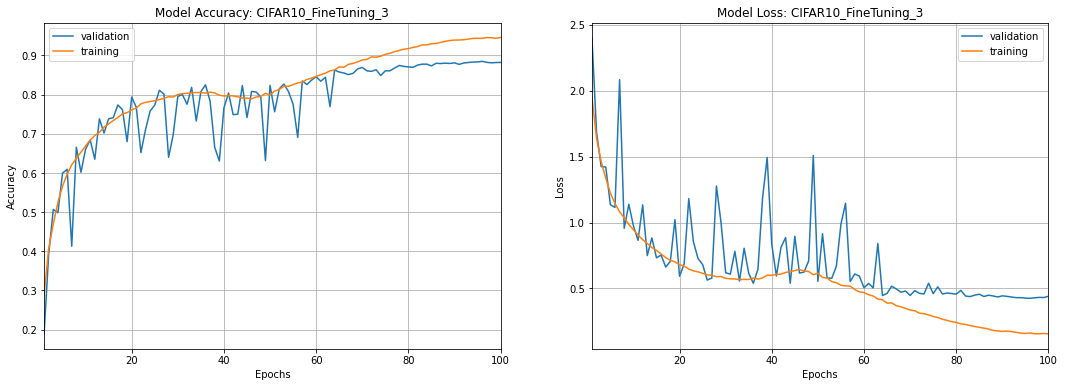

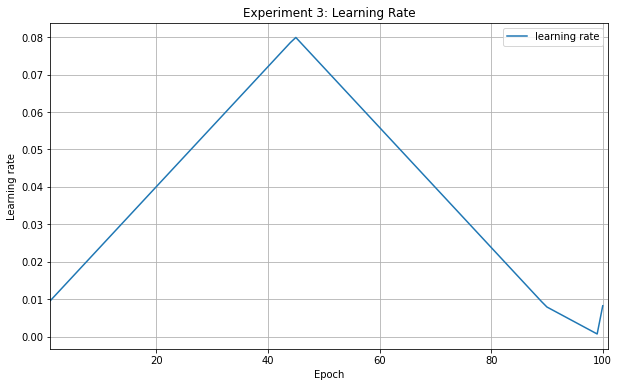

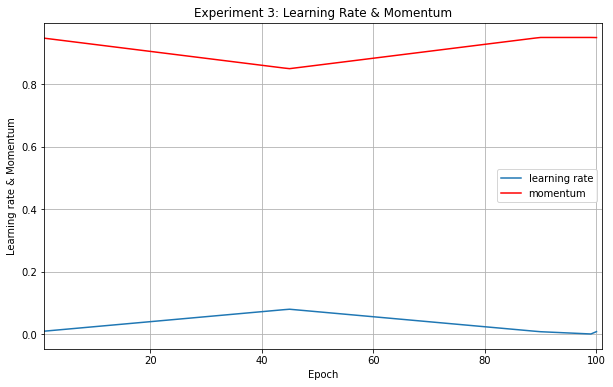

In [28]:
# Load the saved model for making predictions
#model = keras.models.load_model("CIFAR10_FineTuning_3.h5")

numOfEpochs_FineTuning_3 = len(history_FineTuning_3.history['loss'])
print("Epochs: ", numOfEpochs_FineTuning_3)

test_loss_FineTuning_3, test_accuracy_FineTuning_3 = model.evaluate(X_test, y_test, verbose=0)


print("\n{} Test Accuracy: {:.3f}".format(model_name, test_accuracy_FineTuning_3))
print("{} Test Loss: {:.3f}".format(model_name, test_loss_FineTuning_3))


# model.predict(X_test) method return 10 probabilities per class for each instance (Dimension Nx10)
y_test_predicted = model.predict(X_test)
y_test_predicted = np.argmax(y_test_predicted, axis=1) # get the label/index of the highest probability class


print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))


plot_learning_curves(history_FineTuning_3, numOfEpochs_FineTuning_3, 
                     model_name)

plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_FineTuning_3, 
                   "Experiment 3: Learning Rate", momentumPlot=False)


plot_learning_rate(loss_history_oneCycle_cb, numOfEpochs_FineTuning_3, 
                   "Experiment 3: Learning Rate & Momentum", momentumPlot=True)

## Comparison of Validation Accuracy Over Epochs

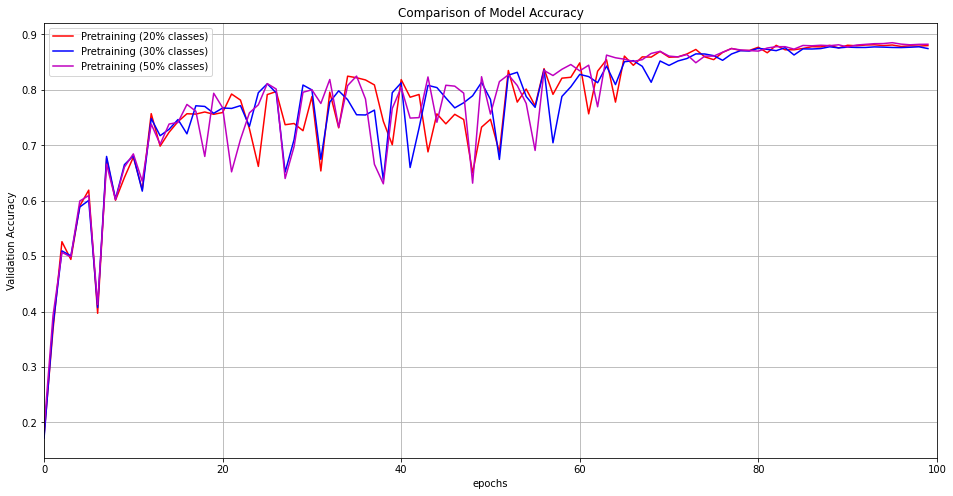

In [31]:
epochs = max(numOfEpochs_FineTuning_1, numOfEpochs_FineTuning_2, numOfEpochs_FineTuning_3)

plt.figure(figsize=(16,8))
plt.plot(range(numOfEpochs_FineTuning_1),history_FineTuning_1.history['val_accuracy'],'r-',
         label='Pretraining (20% classes)')


plt.plot(range(numOfEpochs_FineTuning_2),history_FineTuning_2.history['val_accuracy'],'b-',
         label='Pretraining (30% classes)')



plt.plot(range(numOfEpochs_FineTuning_3),history_FineTuning_3.history['val_accuracy'],'m-',
         label='Pretraining (50% classes)')



plt.legend(loc=0)
plt.xlabel('epochs')
plt.xlim([0,epochs])
plt.ylabel('Validation Accuracy')
plt.grid(True)
plt.title("Comparison of Model Accuracy")
plt.show()


## Comparison of Test Accuracy and Total Number of Epochs

In [35]:
data = [
    ["1. Pretraining (20% classes)", numOfEpochs_FineTuning_1, duration_FineTuning_1, 
     (duration_Pretraining_1_sec+duration_FineTuning_1_sec),
     test_accuracy_FineTuning_1],
    
    ["2. Pretraining (30% classes)", numOfEpochs_FineTuning_2, duration_FineTuning_2, 
     (duration_Pretraining_2_sec+duration_FineTuning_2_sec),
     test_accuracy_FineTuning_2],
    
    
    ["3. Pretraining (50% classes)", numOfEpochs_FineTuning_3, duration_FineTuning_3, 
     (duration_Pretraining_3_sec+duration_FineTuning_3_sec),
     test_accuracy_FineTuning_3]
     ]
    
pd.DataFrame(data, columns=["Experiments", "Epochs", "Fine-Tuning Time", "Pretraining+Fine-Tuning Time", "Test Accuracy"])


,Experiments,Epochs,Fine-Tuning Time,Pretraining+Fine-Tuning Time,Test Accuracy
0,1. Pretraining (20% classes),100,8 min 58 s,555.759828,0.8696
1,2. Pretraining (30% classes),100,8 min 53 s,550.879102,0.8764
2,3. Pretraining (50% classes),100,8 min 52 s,549.965818,0.8704


## Comparative Analysis

Based on the results obtained from the experiments we conclude that using 30% of the classes in pretraining provides highest test accuracy. In general, increasing the fraction of classes increase the accuracy. 

However, we should not use 100% of the classes in pretraining. Because to harness the benefit of pretraining based weight initialization (i.e., to expedite the training time with high accuracy) we must use a smaller subset of the training data (e.g., 20% training data). Increasing the fraction of classes would reduce the amount of training samples per class, which could be detrimental for optimal pretraining. 

Thus, we will have to make a trade-off between the fraction of classes and fraction of total training data to ensure smallest pretraining time.